In [1]:
import pandas as pd # importing pandas
import numpy as np # importing numpy
import matplotlib.pyplot as plt # importing plotting module
import random # importing random
!pip install tabulate
from tabulate import tabulate # importing tabulate

# importing packages for performance metrics
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score, confusion_matrix, accuracy_score, balanced_accuracy_score

from sklearn.model_selection import StratifiedKFold # importing package for stratified fold cross validation
from sklearn.neighbors import KNeighborsClassifier # importing package for kNN classifier

# importing packages for pre-processing
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler 

from sklearn.linear_model import Perceptron # importing package for Perceptron classifier
from sklearn.naive_bayes import GaussianNB # importing package for Gaussian Naive Bayes Classifier
from sklearn.svm import SVC # importing package for SVM classifier

from sklearn.decomposition import PCA # importing package for PCA
from sklearn.model_selection import train_test_split # importing package for splitting data
from sklearn.model_selection import GridSearchCV # importing package for grid search

from sklearn.pipeline import Pipeline # importing package for pipeline
from numpy import savetxt # importing package for saving an array

## Question No. 1: 

#### Load the training and test data files and answer the following questions:

In [2]:
# loading the test and training data
xtest=np.loadtxt('xtest.csv')
xtrain=np.loadtxt('xtrain.csv')
ytrain=np.loadtxt('ytrain.csv')

#### i) How many training and test examples are there? How many positive and negative examples are there in the training dataset?

In [3]:
xtrain.shape # number of rows for xtrain

(3000, 784)

In [4]:
ytrain.shape # number of rows for ytrain

(3000,)

In [5]:
xtest.shape # number of rows for xtest

(3000, 784)

In [6]:
(ytrain>0).sum() # to find the number of positive (+1) labels in ytrain

611

In [7]:
(ytrain<0).sum() # to find the number of negative (-1) labels in ytrain

2389

There are 3000 training and test examples. There are 611 positive examples and 2389 negative examples.

#### ii) Show at least 10 randomly selected objects of each class using plt.matshow by reshaping the flattened array to 28x28. What are your observations about the nature of the data? Also show 10 randomly selected objects from the test set. Do you see any issues in the data that may limit the generalization performance of your classifier?

In [8]:
# finding the indices of the positive and negative labels in the training dataset
pos_list=[]
neg_list=[]
for i,x in enumerate(ytrain):
    if x == 1:
        pos_list.append(i)
    else:
        neg_list.append(i)

In [79]:
# random indices for positive labels
rand_pos_ind = random.sample(pos_list, 10)
# random indices for negative labels
rand_neg_ind = random.sample(neg_list, 10)

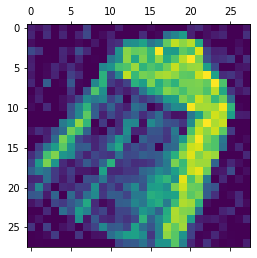

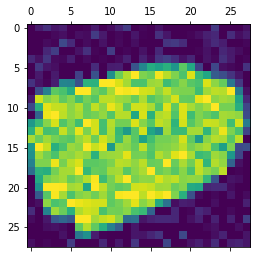

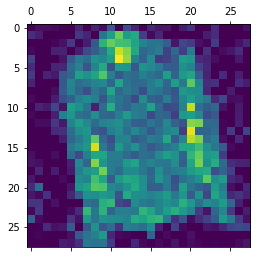

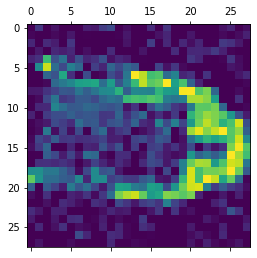

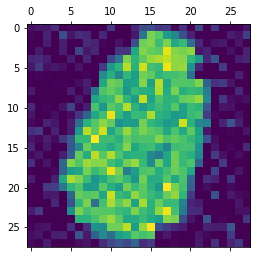

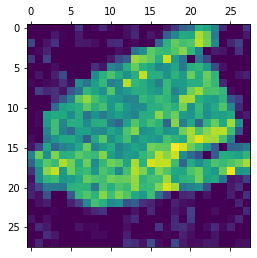

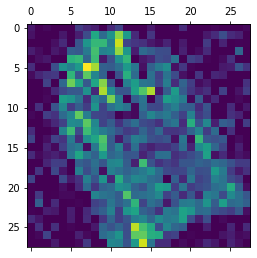

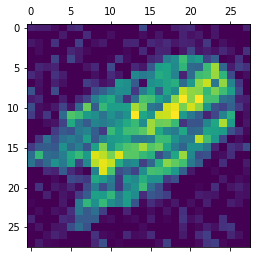

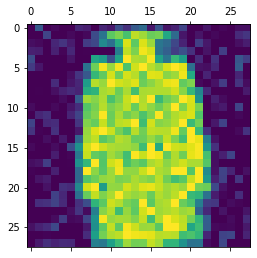

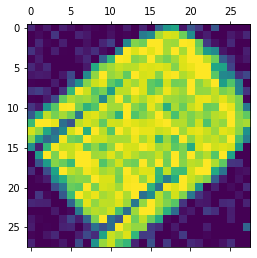

In [80]:
# 10 randomly selected objects in the positive class
for i in rand_pos_ind:
    plt.matshow(xtrain[i].reshape(28,28))

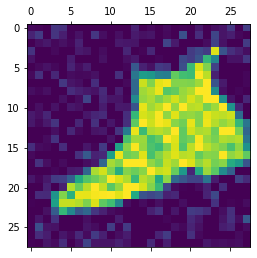

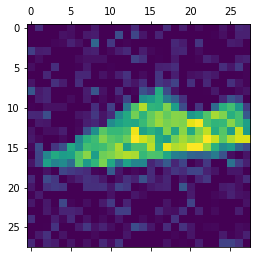

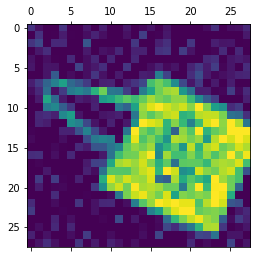

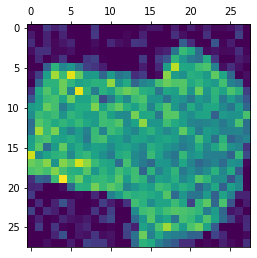

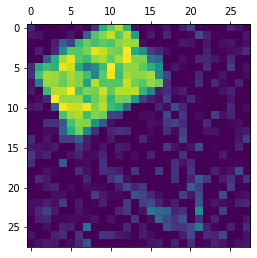

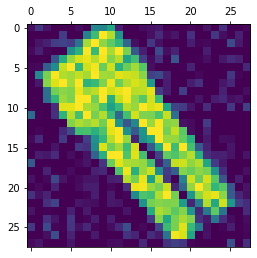

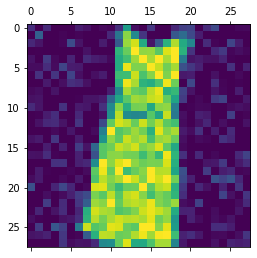

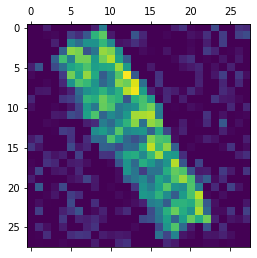

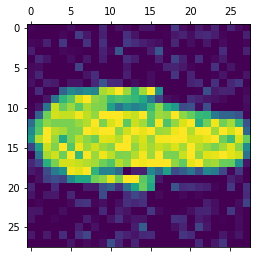

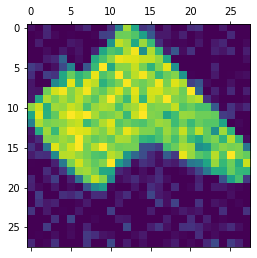

In [81]:
# 10 randomly selected objects in the negative class
for i in rand_neg_ind:
    plt.matshow(xtrain[i].reshape(28,28))

The objects shown are images of clothes, shoes and various accessories. None of the objects are upright. The objects in the positive class seems to be items of clothing with long sleeves (mostly hoodies) while the objects in the negative class seem to be accessories, shoes and other items of clothing.

In [12]:
# random indices from test data
rand_ind = np.random.randint(3000, size=10)

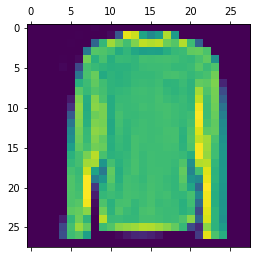

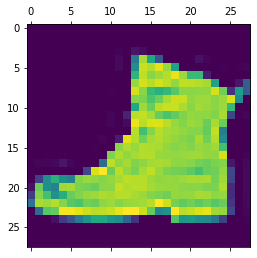

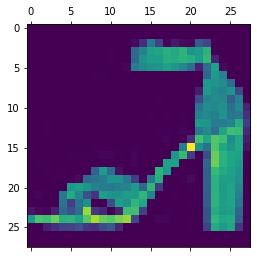

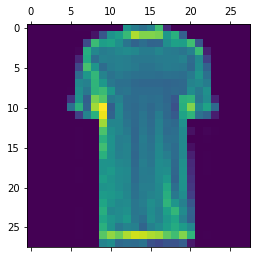

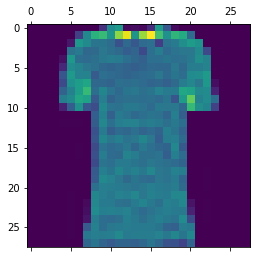

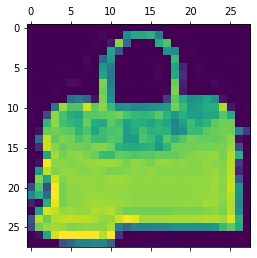

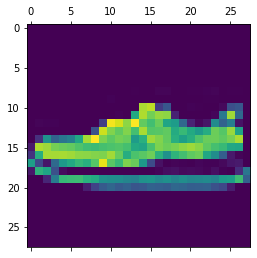

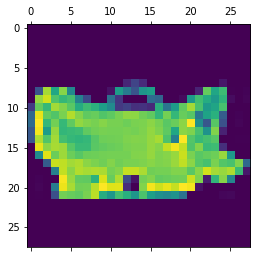

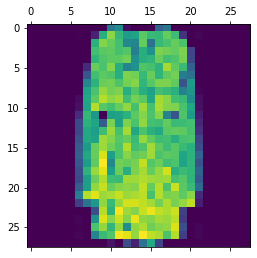

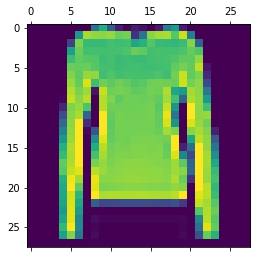

In [13]:
# 10 randomly selected objects from the test data
for i in rand_ind:
    plt.matshow(xtest[i].reshape(28,28))

The test datset are clearer than the training dataset. The pictures are also upright as opposed to the training dataset where the pictures are not straight.

#### iii) Which performance metric (e.g., accuracy, AUC-ROC and AUC-PR) should be used for this problem? Give the reasoning behind your choice(s).

Accuracy and AUC-ROC cannot be used as performance metrices to evaluate the performance because the data points are not equal for both classes. Hence, we cannot use these performance metrix for an unbalanced data set. AUC-PR is used when datasets are heavily imbalanced. Hence, it is suitable for this dataset.

#### iv) What is the expected accuracy of a random classifier (one that generates random labels for a given example) for this problem over the training and test datasets? Demonstrate (either by a mathematical or statistical proof or a programming experiment) why this would be the case.

The expected accuracy of a random classifier is 50%. It is calculated by 1/k where k is the number of classes. Here, k=2. Hence, the expected accuracy is 1/2 = 0.5.

In [14]:
# creating a random list of numbers between -1 and +1 for a random classifier
ypred = []
for i in range(0, 3000):
    x = random.uniform(-1,1)
    ypred.append(x)

In [15]:
# creating labels for the random number list
ytest = []
for i in ypred:
    if i < 0:
        x=-1
    else:
        x=1
    ytest.append(x)

In [16]:
# Accuracy of the random classifier
acc =accuracy_score(ytrain, ytest)
acc

0.509

#### v) What is the AUC-ROC and AUC-PR of a random classifier for this problem over the training and test datasets? Demonstrate (either by a mathematical or statistical proof or a programming experiment) why this would be the case.

The AUC-ROC of a random classifier is 50%.

In [17]:
# AUC-ROC of the random classifier
fpr,tpr,tt = roc_curve(ytrain, ypred)
roc_auc = auc(fpr, tpr)
roc_auc

0.5046869893997242

In [18]:
# AUC-PRC of the random classifier
pr_auc = average_precision_score(ytrain, ypred)
pr_auc

0.2038466075148488

## Question No. 2:

#### Perform 5-fold stratified cross-validation (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) over the training dataset using a k=3 nearest neighbour (kNN) classifier and answer the following questions:

In [19]:
# function for all performance metrics for kNN classifiers
def kNN(xt,yt,xv,yv):
    # fitting kNN classifiers with 3 nearest neighbours
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(xt,yt)

    # predictions
    z = knn.predict(xv)
    zp = knn.predict_proba(xv)

    # performance metrics
    acc = accuracy_score(yv,z)
    b_acc = balanced_accuracy_score(yv,z)
    pr = average_precision_score(yv, zp[:,1])
    fpr,tpr,tt = roc_curve(yv, zp[:,1])
    roc = auc(fpr, tpr)
    
    return acc, b_acc, pr, roc

#### i) What is the accuracy, balanced accuracy, AUC-ROC and AUC-PR for each fold using this classifier? Show code to demonstrate the results. Calculate the average and standard deviation for each metric across all folds and show these in a single table. As the KNN classifier in sklearn does not support decision_function, be sure to understand and use the predict_proba function for AUC-ROC and AUC-PR calculations or plotting.

In [20]:
# 5-fold cross validation over the training dataset 
skf = StratifiedKFold(n_splits=5,shuffle=True)

A=[]
BA=[]
PR=[]
ROC=[]

# splitting the datset into training and validation data
for i,(tr_idx, v_idx) in enumerate(skf.split(xtrain, ytrain)):
    Xtr, Xv = xtrain[tr_idx], xtrain[v_idx]
    ytr, yv = ytrain[tr_idx], ytrain[v_idx]

    knn_acc, knn_bacc, knn_pr, knn_roc = kNN(Xtr, ytr, Xv, yv)

    # array of 5 fold cross validation values for all metrics
    A.append(knn_acc)
    BA.append(knn_bacc)
    PR.append(knn_pr)
    ROC.append(knn_roc)

    # performance metric for each fold
    print(f"Fold {i+1} Accuracy: {round(knn_acc,2)}")
    print(f"Fold {i+1} Balanced Accuracy: {round(knn_bacc,2)}")
    print(f"Fold {i+1} Precision Recall: {round(knn_pr,2)}")
    print(f"Fold {i+1} Receiver Operating Characteristic: {round(knn_roc,2)}")

# mean and standard devaition across all folds for all metrics
mean_acc=round(np.mean(A),2)
std_acc=round(np.std(A),2)
mean_bacc=round(np.mean(BA),2)
std_bacc=round(np.std(BA),2)
mean_pr=round(np.mean(PR),2)
std_pr=round(np.std(PR),2)
mean_roc=round(np.mean(ROC),2)
std_roc=round(np.std(ROC),2)


Fold 1 Accuracy: 0.87
Fold 1 Balanced Accuracy: 0.79
Fold 1 Precision Recall: 0.62
Fold 1 Receiver Operating Characteristic: 0.88
Fold 2 Accuracy: 0.88
Fold 2 Balanced Accuracy: 0.79
Fold 2 Precision Recall: 0.65
Fold 2 Receiver Operating Characteristic: 0.86
Fold 3 Accuracy: 0.89
Fold 3 Balanced Accuracy: 0.81
Fold 3 Precision Recall: 0.71
Fold 3 Receiver Operating Characteristic: 0.89
Fold 4 Accuracy: 0.86
Fold 4 Balanced Accuracy: 0.8
Fold 4 Precision Recall: 0.62
Fold 4 Receiver Operating Characteristic: 0.88
Fold 5 Accuracy: 0.85
Fold 5 Balanced Accuracy: 0.78
Fold 5 Precision Recall: 0.62
Fold 5 Receiver Operating Characteristic: 0.88


Mean and standard devation for each metric in a table is given below

In [21]:
# creating a table for the mean and standard deviation of all performance metrics across all 5 folds
dkNN={
    'Performance Metrics':['Accuracy','Balanced Accuracy', 'PR','ROC'],
    'Mean':[mean_acc, mean_bacc, mean_pr, mean_roc],
    'Standard Deviation':[std_acc, std_bacc, std_pr, std_roc]
}
pd.DataFrame(data=dkNN)

,Performance Metrics,Mean,Standard Deviation
0,Accuracy,0.87,0.01
1,Balanced Accuracy,0.80,0.01
2,PR,0.64,0.03
3,ROC,0.88,0.01


#### ii) Plot the ROC and PR curves for one fold. What are your observations about the ROC and PR curves?

In [22]:
# functions for plotting ROC and PRC 
def plotROC(y,z,pstr = ''):
    
    # ROC functions from sklearn
    fpr,tpr,tt = roc_curve(y, z) 
    roc_auc = auc(fpr, tpr)
    f,ax=plt.subplots()
    ax.plot(fpr,tpr,'o-') 
    
    # formatting the plot
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid()
    plt.title('ROC '+pstr)
    
    return ax

def plotPRC(y,z,pstr = ''):
    
    # PR functions from sklearn
    P,R,tt = precision_recall_curve(y, z)
    pr_auc = average_precision_score(y, z)
    f,ax=plt.subplots()
    ax.plot(R,P,'o-')
    
    # formatting the plot
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid()
    plt.title('PRC '+pstr)
    
    return ax

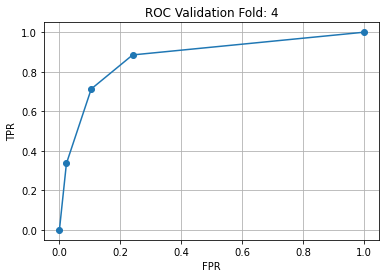

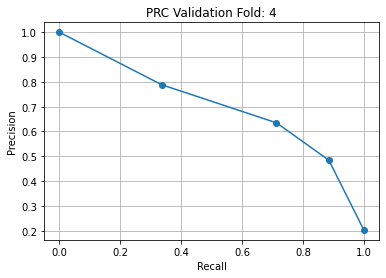

In [23]:
# splitting the datset into training and validation data
random_index = random.randint(0,4)
for i,(tr_idx, v_idx) in enumerate(skf.split(xtrain, ytrain)):
    Xtr, Xv = xtrain[tr_idx], xtrain[v_idx]
    ytr, yv = ytrain[tr_idx], ytrain[v_idx]
    
    # fitting kNN classifiers with 3 nearest neighbours
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(Xtr,ytr)
    
    # predictions
    z = knn.predict_proba(Xv)
    
    # plotting ROC and PR curves for kNN classifier for a random fold
    if random_index == i:
        roc_auc = plotROC(yv,z[:,1],pstr = 'Validation Fold: '+str(i+1))
        prc_auc = plotPRC(yv,z[:,1],pstr = 'Validation Fold: '+str(i+1))

ROC Curve: The curve is further away from the 45 degress diagonal which show a better performance. The TRP rises up to around 60% while FPR is around 0. While FPR increases to 20%, the TPR is at 80%. Hence the true positive rate is higher than the false positive rate. The closer the curve is to the left of the graph, the better the classifier is to separate the two classes.

PR Curve: In the PR curve, the precision decreases as the true positive rate increases. The precision is at 100% when the TPR is at 0. To reach a precision of 50%, the TPR has to be more than 0.8. The PR curve separates the classes not too poorly but it isn't perfect separation either. 

#### iii) What is the impact of various forms of pre-processing (https://scikit-learn.org/stable/modules/preprocessing.html ) (e.g., mean-standard deviation or standard scaling or min-max scaling) on the cross-validation performance? Show code to demonstrate the results and write a summary of your findings. Do any pre-processing techniques improve predictive performance? Why do you think this is the case?

In [24]:
# function for preprocessing
def Preprocessing(Xtr, Xv, method=''):
    
    if method == 'StandardScaler':
        # standardisation of the dataset with StandardScaler
        scaler = preprocessing.StandardScaler().fit(Xtr)
        Xtr_tran = scaler.transform(Xtr)
        Xv_tran = scaler.transform(Xv)
    elif method == 'MeanStd':    
        # standardisation of the dataset with Mean Standard Deviation
        Xtr_tran = (Xtr - Xtr.mean())/Xtr.std()
        Xv_tran = (Xv - Xv.mean())/Xv.std()
    elif method == 'MinMaxScalar':
        # standardisation of the dataset with MinMaxScaler
        min_max_scaler = preprocessing.MinMaxScaler()
        Xtr_tran = min_max_scaler.fit_transform(Xtr)
        Xv_tran = min_max_scaler.fit_transform(Xv)
    else:
        Xtr_tran = Xtr
        Xv_tran = Xv
    
    return Xtr_tran, Xv_tran

In [25]:
# function for 5 fold stratified cross validation
def strat5fold(xtr,yt,classifier,prepr_method=''):
    A=[]
    BA=[]
    PR=[]
    ROC=[]

    # splitting the datset into training and validation data
    for i,(tr_idx, v_idx) in enumerate(skf.split(xtr, yt)):
        Xtr, Xv = xtr[tr_idx], xtr[v_idx]
        ytr, yv = yt[tr_idx], yt[v_idx]

        Xtr,Xv=Preprocessing(Xtr,Xv,prepr_method)

        acc, bacc, pr, roc = classifier(Xtr, ytr, Xv, yv)

        # array of 5 fold cross validation values for all metrics
        A.append(acc)
        BA.append(bacc)
        PR.append(pr)
        ROC.append(roc)

    # mean and standard devaition across all folds for all metrics
    mean_acc=round(np.mean(A),2)
    std_acc=round(np.std(A),2)
    mean_bacc=round(np.mean(BA),2)
    std_bacc=round(np.std(BA),2)
    mean_pr=round(np.mean(PR),2)
    std_pr=round(np.std(PR),2)
    mean_roc=round(np.mean(ROC),2)
    std_roc=round(np.std(ROC),2)

    return mean_acc, std_acc, mean_bacc, std_bacc, mean_pr, std_pr, mean_roc, std_roc

In [26]:
# using Mean Standard Deviation
msmean_a,msstd_a,msmean_b,msstd_b,msmean_p,msstd_p,msmean_r,msstd_r=strat5fold(xtrain,ytrain,kNN,'MeanStd')

In [27]:
# creating a table for the mean and standard deviation of all performance metrics across all 5 folds after mean standard deviation preprocessing
dk={
    'Performance Metrics':['Accuracy','Balanced Accuracy', 'PR','ROC'],
    'Mean':[msmean_a, msmean_b, msmean_p, msmean_r],
    'Standard Deviation':[msstd_a, msstd_b, msstd_p, msstd_r]
}
pd.DataFrame(data=dk)

,Performance Metrics,Mean,Standard Deviation
0,Accuracy,0.87,0.00
1,Balanced Accuracy,0.79,0.02
2,PR,0.64,0.03
3,ROC,0.88,0.01


In [28]:
# using StandardScaler
smean_a,sstd_a,smean_b,sstd_b,smean_p,sstd_p,smean_r,sstd_r=strat5fold(xtrain,ytrain,kNN,'StandardScaler')

In [29]:
# creating a table for the mean and standard deviation of all performance metrics across all 5 folds after standard scalar preprocessing
dk={
    'Performance Metrics':['Accuracy','Balanced Accuracy', 'PR','ROC'],
    'Mean':[smean_a, smean_b, smean_p, smean_r],
    'Standard Deviation':[sstd_a, sstd_b, sstd_p, sstd_r]
}
pd.DataFrame(data=dk)

,Performance Metrics,Mean,Standard Deviation
0,Accuracy,0.87,0.01
1,Balanced Accuracy,0.79,0.01
2,PR,0.64,0.03
3,ROC,0.88,0.01


In [30]:
# using MinMaxScaler
mmean_a,mstd_a,mmean_b,mstd_b,mmean_p,mstd_p,mmean_r,mstd_r=strat5fold(xtrain,ytrain,kNN,'MinMaxScalar')

In [31]:
# creating a table for the mean and standard deviation of all performance metrics across all 5 folds after minmaxscaler preprocessing
dk={
    'Performance Metrics':['Accuracy','Balanced Accuracy', 'PR','ROC'],
    'Mean':[msmean_a, msmean_b, msmean_p, msmean_r],
    'Standard Deviation':[msstd_a, msstd_b, msstd_p, msstd_r]
}
pd.DataFrame(data=dk)

,Performance Metrics,Mean,Standard Deviation
0,Accuracy,0.87,0.00
1,Balanced Accuracy,0.79,0.02
2,PR,0.64,0.03
3,ROC,0.88,0.01


After using the different forms of preprocessing, it is clear that all three forms give the same values for the performance  metrices for the 5 fold stratified cross validation kNN classifier. However, StandardScaler has a marginal increase in the accuracy scores. Given this observation, all the forms do not seem to have an effect on the predictive performance as the performance metrices have the same scores before and after preprocessing. 

## Question No. 3:

#### Use 5-fold stratified cross-validation over training data to choose an optimal classifier between: Perceptron, Naïve Bayes Classifier, Linear SVM and Kernelized SVM. Be sure to tune the hyperparameters of each classifier type (C and kernel type and kernel hyper-parameters for SVM etc). Report the cross validation results (mean and standard deviation of accuracy, balanced accuracy, AUC-ROC and AUC-PR across fold) of your best model. You may look into grid search as well as ways of pre-processing data.

#### i) Write your strategy for selecting the optimal classifier. Show code to demonstrate the results for each classifier.

In [32]:
# function for Perceptron classifier for all performance metrices
def per(xt,yt,xv,yv):
    
    # fitting Perceptron classifier
    pct = Perceptron()
    pct.fit(xt, yt)

    # predictions
    z = pct.predict(xv)
    zp = pct.decision_function(xv)

    # performance metrics
    acc = accuracy_score(yv,z)
    b_acc = balanced_accuracy_score(yv,z)
    prc = average_precision_score(yv, zp)
    fpr,tpr,tt = roc_curve(yv, zp)
    roc = auc(fpr, tpr)
    
    return acc, b_acc, prc, roc

In [33]:
# reporting results of Perceptron as a table
pmean_a,pstd_a,pmean_b,pstd_b,pmean_p,pstd_p,pmean_r,pstd_r=strat5fold(xtrain,ytrain,per,'StandardScaler')

data_p={
    'Performance Metrics':['Accuracy','Balanced Accuracy', 'PR','ROC'],
    'Mean':[pmean_a, pmean_b, pmean_p, pmean_r],
    'Standard Deviation':[pstd_a, pstd_b, pstd_p, pstd_r]
}
pd.DataFrame(data=data_p)

,Performance Metrics,Mean,Standard Deviation
0,Accuracy,0.80,0.03
1,Balanced Accuracy,0.72,0.06
2,PR,0.55,0.10
3,ROC,0.80,0.05


In [34]:
# function for all performance metrics for Naive Bayes classifier
def NB(xt,yt,xv,yv):
    
    # fitting Gaussian Naive Bayes classifier
    gnb = GaussianNB()
    gnb.fit(xt, yt)

    # predictions
    z = gnb.predict(Xv)
    zp = gnb.predict_proba(Xv)

    # performance metrics
    acc = accuracy_score(yv,z)
    b_acc = balanced_accuracy_score(yv,z)
    prc = average_precision_score(yv, zp[:,1])
    fpr,tpr,tt = roc_curve(yv, zp[:,1])
    roc = auc(fpr, tpr)
    
    return acc, b_acc, prc, roc

In [35]:
# reporting results of Naive Bayes as a table
nmean_a,nstd_a,nmean_b,nstd_b,nmean_p,nstd_p,nmean_r,nstd_r=strat5fold(xtrain,ytrain,NB,'StandardScaler')

data_n={
    'Performance Metrics':['Accuracy','Balanced Accuracy', 'PR','ROC'],
    'Mean':[nmean_a, nmean_b, nmean_p, nmean_r],
    'Standard Deviation':[nstd_a, nstd_b, nstd_p, nstd_r]
}
pd.DataFrame(data=data_n)

,Performance Metrics,Mean,Standard Deviation
0,Accuracy,0.80,0.0
1,Balanced Accuracy,0.50,0.0
2,PR,0.21,0.0
3,ROC,0.50,0.0


In [36]:
# fitting linear SVM classifier
lsvc = SVC()

# grid search for hyperparameters for linear svm
parameters=[{
    'C':[1,10,100,1000],
    'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'kernel': ['linear'],
    'class_weight': ['balanced']
}]
grid_searchl=GridSearchCV(estimator=lsvc,
                         param_grid=parameters,
                         cv=5)
grid_searchl.fit(xtrain, ytrain)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'class_weight': ['balanced'],
                          'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                    1.0],
                          'kernel': ['linear']}])

In [37]:
# finding the best parameters
grid_searchl.best_params_

{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'linear'}

In [38]:
# function for all performance metrics for Linear SVM classifier
def l_svm(xt,yt,xv,yv):
    
    # fitting Linear SVM classifier
    lsvc = SVC(C=1, class_weight='balanced', gamma=0.1, kernel='linear')
    lsvc.fit(xt, yt)
    
    # predictions
    z = lsvc.predict(xv)
    zp = lsvc.decision_function(xv)

    # performance metrics
    acc = accuracy_score(yv,z)
    b_acc = balanced_accuracy_score(yv,z)
    prc = average_precision_score(yv, zp)
    fpr,tpr,tt = roc_curve(yv, zp)
    roc = auc(fpr, tpr)
    
    return acc, b_acc, prc, roc

In [39]:
# reporting results of Linear SVM as a table
lmean_a,lstd_a,lmean_b,lstd_b,lmean_p,lstd_p,lmean_r,lstd_r=strat5fold(xtrain,ytrain,l_svm,'StandardScaler')

data_l={
    'Performance Metrics':['Accuracy','Balanced Accuracy', 'PR','ROC'],
    'Mean':[lmean_a, lmean_b, lmean_p, lmean_r],
    'Standard Deviation':[lstd_a, lstd_b, lstd_p, lstd_r]
}
pd.DataFrame(data=data_l)

,Performance Metrics,Mean,Standard Deviation
0,Accuracy,0.77,0.01
1,Balanced Accuracy,0.69,0.02
2,PR,0.48,0.03
3,ROC,0.76,0.02


In [40]:
# fitting kernelised SVM classifier
ksvc = SVC()

# grid search for hyperparameters
parameters=[{
    'C':[1,10,100,1000],
    'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'kernel': ['rbf','poly'],
    'class_weight': ['balanced']
}]
grid_searchk=GridSearchCV(estimator=ksvc,
                         param_grid=parameters,
                         cv=5)
grid_searchk.fit(xtrain, ytrain)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'class_weight': ['balanced'],
                          'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                    1.0],
                          'kernel': ['rbf', 'poly']}])

In [41]:
# finding the best parameters
grid_searchk.best_params_

{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'poly'}

In [42]:
# function for all performance metrics for Kernelised SVM classifier
def k_svm(xt,yt,xv,yv):
    
    # fitting Kernelised SVM classifier
    ksvc = SVC(C=1, class_weight='balanced', gamma=0.1, kernel='poly')
    ksvc.fit(xt, yt)
    
    # predictions
    z = ksvc.predict(xv)
    zp = ksvc.decision_function(xv)

    # performance metrics
    acc = accuracy_score(yv,z)
    b_acc = balanced_accuracy_score(yv,z)
    prc = average_precision_score(yv, zp)
    fpr,tpr,tt = roc_curve(yv, zp)
    roc = auc(fpr, tpr)
    
    return acc, b_acc, prc, roc

In [43]:
# reporting results of Kernalised SVM as a table
kmean_a,kstd_a,kmean_b,kstd_b,kmean_p,kstd_p,kmean_r,kstd_r=strat5fold(xtrain,ytrain,k_svm,'StandardScaler')

data_k={
    'Performance Metrics':['Accuracy','Balanced Accuracy', 'PR','ROC'],
    'Mean':[kmean_a, kmean_b, kmean_p, kmean_r],
    'Standard Deviation':[kstd_a, kstd_b, kstd_p, kstd_r]
}
pd.DataFrame(data=data_k)

,Performance Metrics,Mean,Standard Deviation
0,Accuracy,0.87,0.01
1,Balanced Accuracy,0.75,0.02
2,PR,0.73,0.02
3,ROC,0.92,0.01


The performance metrics scores for Kernalised SVM classifier is higher than other classifiers. However, since the data set is highly unbalanced, the ideal performance metric that is often used is the PR score. Here, the mean PR scores across all 5 folds for the Kernelised SVM is relatively higher than the other three classifiers. Hence, this is the best model. The cross validation results of the Kernalised SVM is shown in the table below:

In [44]:
pd.DataFrame(data=data_k)

,Performance Metrics,Mean,Standard Deviation
0,Accuracy,0.87,0.01
1,Balanced Accuracy,0.75,0.02
2,PR,0.73,0.02
3,ROC,0.92,0.01


#### ii) Show the comparison of these classifiers using a single consolidated table.

In [45]:
# creating a consolidated table
table=[]

# appending the values of the Perceptron classifier
table.append(['Perceptron', 
              '\n'.join(['Accuracy','Balanced Accuracy', 'PR','ROC']), 
              '\n'.join([str(pmean_a), str(pmean_b), str(pmean_p), str(pmean_r)]),
              '\n'.join([str(pstd_a), str(pstd_b), str(pstd_p), str(pstd_r)])
             ])

# appending the values of the Naive Bayes classifier
table.append(['Naive Bayes', 
              '\n'.join(['Accuracy','Balanced Accuracy', 'PR','ROC']), 
              '\n'.join([str(nmean_a), str(nmean_b), str(nmean_p), str(nmean_r)]),
              '\n'.join([str(nstd_a), str(nstd_b), str(nstd_p), str(nstd_r)])
             ])

# appending the values of the Linear SVM classifier
table.append(['Linear SVM', 
              '\n'.join(['Accuracy','Balanced Accuracy', 'PR','ROC']), 
              '\n'.join([str(lmean_a), str(lmean_b), str(lmean_p), str(lmean_r)]),
              '\n'.join([str(lstd_a), str(lstd_b), str(lstd_p), str(lstd_r)])
             ])

# appending the values of the Kernelised SVM classifier
table.append(['Kernelised SVM', 
              '\n'.join(['Accuracy','Balanced Accuracy', 'PR','ROC']), 
              '\n'.join([str(kmean_a), str(kmean_b), str(kmean_p), str(kmean_r)]),
              '\n'.join([str(kstd_a), str(kstd_b), str(kstd_p), str(kstd_r)])
             ])

# printing the consolidated table with column headings
print(tabulate(table, ["Classifiers", "Performance Metrics", "Mean", "Standard Deviation"], "grid"))

+----------------+-----------------------+--------+----------------------+
| Classifiers    | Performance Metrics   | Mean   | Standard Deviation   |
+================+=======================+========+======================+
| Perceptron     | Accuracy              | 0.8    | 0.03                 |
|                | Balanced Accuracy     | 0.72   | 0.06                 |
|                | PR                    | 0.55   | 0.1                  |
|                | ROC                   | 0.8    | 0.05                 |
+----------------+-----------------------+--------+----------------------+
| Naive Bayes    | Accuracy              | 0.8    | 0.0                  |
|                | Balanced Accuracy     | 0.5    | 0.0                  |
|                | PR                    | 0.21   | 0.0                  |
|                | ROC                   | 0.5    | 0.0                  |
+----------------+-----------------------+--------+----------------------+
| Linear SVM     | Accura

#### iii) Plot the ROC curves of all classifiers on the same axes for easy comparison.

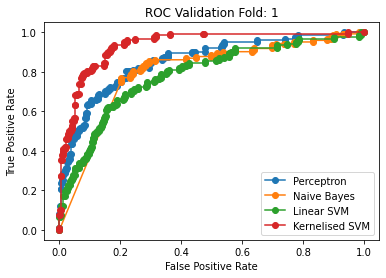

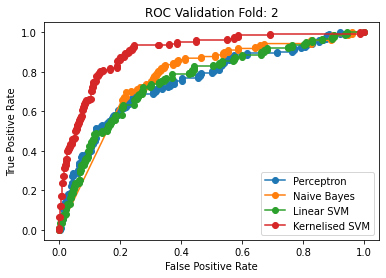

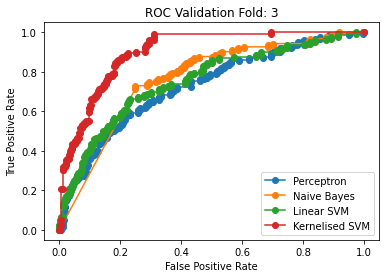

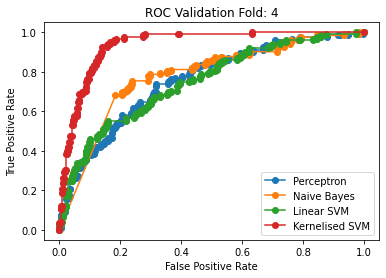

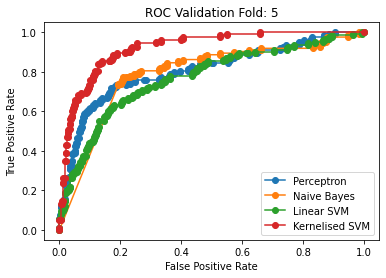

In [46]:
# splitting the datset into training and validation data
for i,(tr_idx, v_idx) in enumerate(skf.split(xtrain, ytrain)):
    Xt, X = xtrain[tr_idx], xtrain[v_idx]
    ytr, yv = ytrain[tr_idx], ytrain[v_idx]
    
    # standardisation of the dataset with StandardScaler
    scaler = preprocessing.StandardScaler().fit(Xt)
    Xtr = scaler.transform(Xt)
    Xv = scaler.transform(X)
    
    plt.figure()
    # Perceptron classifier
    pct = Perceptron()
    pct.fit(Xtr, ytr)
    zp = pct.decision_function(Xv) # predictions
    
    # plotting the roc curve
    fpr_p,tpr_p,tt_p = roc_curve(yv, zp)
    roc_auc_p = auc(fpr_p, tpr_p)
    p1,=plt.plot(fpr_p,tpr_p,'o-',label="Perceptron")
    
    
    # Naive Bayes classifier
    gnb = GaussianNB()
    gnb.fit(Xtr, ytr)
    zn = gnb.predict_proba(Xv) # predictions
    
    # plotting the roc curve
    fpr_n,tpr_n,tt_n = roc_curve(yv, zn[:,1])
    roc_auc_n = auc(fpr_n, tpr_n)
    p2,=plt.plot(fpr_n,tpr_n,'o-',label="Naive Bayes")
    
    
    # Linear SVM classifier
    lsvc = SVC(C=1, class_weight='balanced', gamma=0.1, kernel='linear')
    lsvc.fit(Xtr, ytr)
    zl = lsvc.decision_function(Xv) # predictions
    
    # plotting the roc curve
    fpr_l,tpr_l,tt_l = roc_curve(yv, zl)
    roc_auc_l = auc(fpr_l, tpr_l)
    p3,=plt.plot(fpr_l,tpr_l,'o-',label="Linear SVM")
    
    
    # Kernelised SVM classifier
    ksvc = SVC(C=1, class_weight='balanced', gamma=0.1, kernel='poly')
    ksvc.fit(Xtr, ytr)
    zk = ksvc.decision_function(Xv) # predictions
    
    # plotting the roc curve
    fpr_k,tpr_k,tt_k = roc_curve(yv, zk)
    roc_auc_k = auc(fpr_k, tpr_k)
    p4,=plt.plot(fpr_k,tpr_k,'o-',label="Kernelised SVM")
    
    
    # formatting the graph
    plt.legend(handles=[p1,p2,p3,p4],loc='lower right')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Validation Fold: "+str(i+1))

#### iv) Plot the PR curves of all classifier on the same axes for comparison.

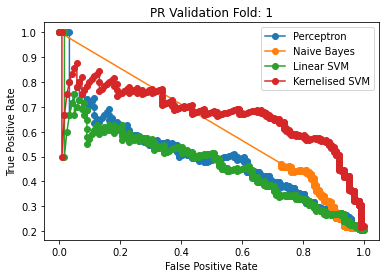

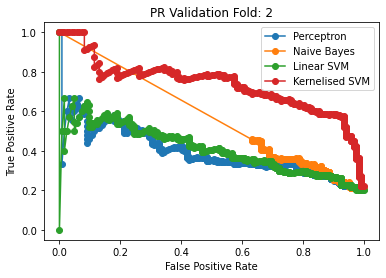

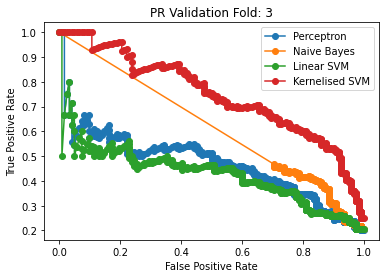

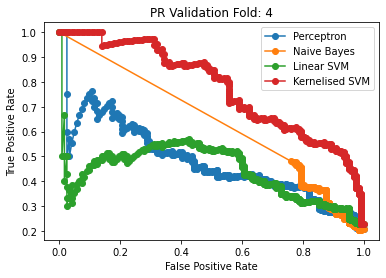

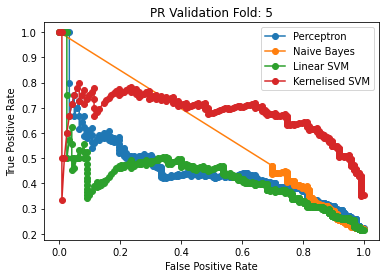

In [47]:
# splitting the datset into training and validation data
for i,(tr_idx, v_idx) in enumerate(skf.split(xtrain, ytrain)):
    Xt, X = xtrain[tr_idx], xtrain[v_idx]
    ytr, yv = ytrain[tr_idx], ytrain[v_idx]
    
    # standardisation of the dataset with StandardScaler
    scaler = preprocessing.StandardScaler().fit(Xt)
    Xtr = scaler.transform(Xt)
    Xv = scaler.transform(X)
    
    plt.figure()
    # Perceptron classifier
    pct = Perceptron(eta0=0.1, random_state=1)
    pct.fit(Xtr, ytr)
    zp = pct.decision_function(Xv) # predictions
    
    # plotting the pr curve
    P_p,R_p,tt_p = precision_recall_curve(yv, zp)   
    p1,=plt.plot(R_p,P_p,'o-',label="Perceptron")
    
    
    # Naive Bayes classifier
    gnb = GaussianNB()
    gnb.fit(Xtr, ytr)
    zn = gnb.predict_proba(Xv) # predictions
    
    # plotting the pr curve
    P_n,R_n,tt_n = precision_recall_curve(yv, zn[:,1])
    p2,=plt.plot(R_n,P_n,'o-',label="Naive Bayes")
    
    
    # Linear SVM classifier
    lsvc = SVC(C=1, class_weight='balanced', gamma=0.1, kernel='linear')
    lsvc.fit(Xtr, ytr)
    zl = lsvc.decision_function(Xv) # predictions
    
    # plotting the pr curve
    P_l,R_l,tt_l = precision_recall_curve(yv, zl)
    p3,=plt.plot(R_l,P_l,'o-',label="Linear SVM")
    
    
    # Kernelised SVM classifier
    ksvc = SVC(C=1, class_weight='balanced', gamma=0.1, kernel='poly')
    ksvc.fit(Xtr, ytr)
    zk = ksvc.decision_function(Xv) # predictions
    
    # plotting the pr curve
    P_k,R_k,tt_k = precision_recall_curve(yv, zk)
    p4,=plt.plot(R_k,P_k,'o-',label="Kernelised SVM")
    
    
    # formatting the graph
    plt.legend(handles=[p1,p2,p3,p4],loc='upper right')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("PR Validation Fold: "+str(i+1))

#### v) Write your observations about the ROC and PR curves.

ROC curves: Across all 5 folds, it is seen that Kernalised SVM shows a higher ROC curve. The ROC scores are higher than other classifiers. The ROC curves for Naive Bayes, Perceptron and Linear SVM are vary close to each other. They are still good classifiers as they are above the 45-degree line. The ROC curve of the Kernalised SVM are closer to the top left corner than the rest which indicates a better classifier.

PR curves: Across all folds, the Kernalised SVM has a better PR score than the other 3 classifiers. Linear SVM and Perceptron have PR curves below the 50% line, which shows that the separation ability between the classes is poor. Naive Bayes classifier a score around 50% for all folds. Hence, the classifier is not very efficient. The Kernalised SVM can separate the classes well but not perfect.

## Question No. 4:

#### i) Reduce the number of dimensions of the training data using PCA to 2 and plot a scatter plot of the training data showing examples of each class in a different color. What are your observations about the data based on this plot?

In [48]:
# reducing number of dimensions for training data to 2
pca = PCA(n_components=2)
pca.fit(xtrain)
projected_tr = pca.transform(xtrain)

Text(0.5, 1.0, 'Scatter Plot for the Training Data')

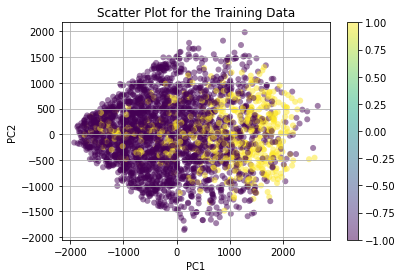

In [49]:
# scatter plot of training data of each class
plt.scatter(projected_tr[:, 0], projected_tr[:, 1],
            c=ytrain, edgecolor='none',alpha =0.5)
plt.grid()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.title('Scatter Plot for the Training Data')

Examples of one class with the label '-1' are shown in violet and examples of another class with label '1' are shown in yellow. From the scatter plot, it is seen that most of the data of both examples are overlapping. There is no evident separation between the two classes from the above graph.

#### ii) Reduce the number of dimensions of the training and test data together using PCA to 2 and plot a scatter plot of the training and test data showing examples of each set in a different color (or marker style). What are your observations about the data based on this plot?

In [50]:
# reducing number of dimensions for testing data to 2
projected_test = pca.transform(xtest) 

Text(0.5, 1.0, 'Scatter Plot for the Training and Test Data')

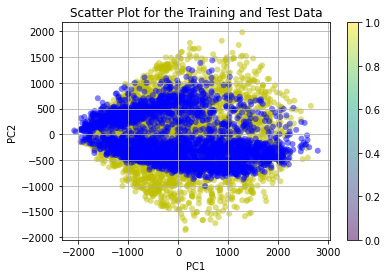

In [51]:
# scatter plot of training data and testing data together
plt.scatter(projected_tr[:, 0], projected_tr[:, 1],
            c='y', edgecolor='none',alpha =0.5)
plt.scatter(projected_test[:, 0], projected_test[:, 1],
            c='b', edgecolor='none',alpha =0.5)
plt.grid()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.title('Scatter Plot for the Training and Test Data')

The examples from the training dataset are shown in yellow and the examples from the test datset are shown in blue. From the scatter plot, it is seen that the training dataset is scattered across the plot. However, the test dataset is compressed to the centre. It is also seen that the test dataset is overlapping the training dataset.

#### iii) Plot the scree graph of PCA and find the number of dimensions that explain 95% variance in the training set.

In [52]:
# PCA with 784 dimensions
pca784 = PCA(n_components=784)
pca784.fit(xtrain)
projected = pca784.transform(xtrain)

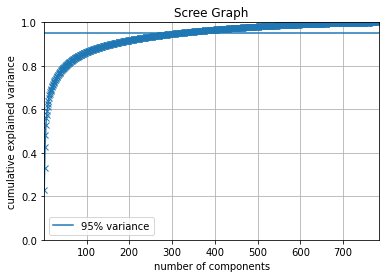

In [53]:
#plotting the scree graph
plt.plot(np.arange(len(pca784.explained_variance_ratio_))+1,np.cumsum(pca784.explained_variance_ratio_),'x-') 
plt.axis([1,len(pca784.explained_variance_ratio_),0,1])
plt.axhline(y=0.95, label="95% variance")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.title('Scree Graph')
plt.grid()
plt.legend()

In [54]:
# 95% variance of the training dataset
pca95 = PCA(n_components=0.95)
pca95.fit(xtrain)
projected = pca95.transform(xtrain)

In [55]:
# number of dimensions
pca95.n_components_

314

314 dimensions that explain 95% variance in the training data set.

#### iv) Reduce the number of dimensions of the data using PCA and perform classification. What is the (optimal) cross-validation performance of a Kernelized SVM classification with PCA? Remember to perform hyperparameter optimization!

In [56]:
# PCA with 314 dimensions
pca314 = PCA(n_components=314)
pca314.fit(xtrain)
projected = pca314.transform(xtrain)

In [57]:
# splitting the dataset
Xtr, Xv, ytr, yv = train_test_split(projected, ytrain, test_size=0.4, random_state=0)

In [58]:
# fitting kernelised SVM classifier
ksvc = SVC()

# grid search
parameters=[{
    'C':[1,10,100,1000],
    'gamma':[0.1, 0.2, 0.3, 0.4],
    'kernel': ['rbf','poly'],
    'class_weight': ['balanced']
}]
grid_search=GridSearchCV(estimator=ksvc,
                         param_grid=parameters,
                         cv=2)
grid_search.fit(Xtr, ytr)

GridSearchCV(cv=2, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'class_weight': ['balanced'],
                          'gamma': [0.1, 0.2, 0.3, 0.4],
                          'kernel': ['rbf', 'poly']}])

In [59]:
# finding the best parameters
grid_search.best_params_

{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'poly'}

In [60]:
# predictions
z = grid_search.predict(Xv)
zp = grid_search.decision_function(Xv)
        
# performance metrics
acc = accuracy_score(yv,z)
b_acc = balanced_accuracy_score(yv,z)
prc = average_precision_score(yv, zp)
fpr,tpr,tt = roc_curve(yv, zp)
roc = auc(fpr, tpr)

In [61]:
# creating a table for the mean and standard deviation of all performance metrics 
d={
    'Performance Metrics':['Accuracy','Balanced Accuracy', 'PR','ROC'],
    'Values':[acc, b_acc, prc, roc]
}
pd.DataFrame(data=d)

,Performance Metrics,Values
0,Accuracy,0.881667
1,Balanced Accuracy,0.813423
2,PR,0.718629
3,ROC,0.922364


## Question No. 5:

#### Develop an optimal pipeline for classification based on your analysis (Q1-Q4). You are free to use any tools or approaches at your disposal. However, no external data sources may be used. Describe your pipeline and report your outputs over the test data set. (You are required to submit your prediction file together with the assignment in a zip folder). Your prediction file should be a single column file containing the prediction score of the corresponding example in Xtest (be sure to have the same order as the order of the test examples in Xtest!). Your prediction file should be named by your student ID, e.g., u100011.csv.

In [62]:
# splitting the dataset
Xtr, Xv, ytr, yv = train_test_split(xtrain, ytrain, test_size=0.4, random_state=0)

# setting up a pipeline
pipe = Pipeline([
('scaler', StandardScaler()),
('decomposer', PCA()),
('classifier', SVC())
])

# fitting the pipeline
pipe.fit(Xtr, ytr)

Pipeline(steps=[('scaler', StandardScaler()), ('decomposer', PCA()),
                ('classifier', SVC())])

In [63]:
# grid search
parameters = {
    'scaler': [StandardScaler(), MinMaxScaler(), Normalizer()],
    'decomposer__n_components': [314],
    'classifier__C': [2,4,6,8,10],
    'classifier__gamma': [0.1,0.2,0.3,0.4,0.5],
    'classifier__kernel': ['rbf','poly','linear']
}

grid = GridSearchCV(
    estimator=pipe, 
    param_grid=parameters, 
    cv=2)
grid.fit(Xtr, ytr)

# predictions
z = grid.predict(Xv)
zp = grid.decision_function(Xv)
        
# performance metrics
acc_pipe = accuracy_score(yv,z)
b_acc_pipe = balanced_accuracy_score(yv,z)
prc_pipe = average_precision_score(yv, zp)
fpr,tpr,tt = roc_curve(yv, zp)
roc_pipe = auc(fpr, tpr)

In [64]:
# optimal parameters
grid.best_params_

{'classifier__C': 4,
 'classifier__gamma': 0.4,
 'classifier__kernel': 'rbf',
 'decomposer__n_components': 314,
 'scaler': Normalizer()}

The training data has to be split between training and test data with a 60-40 split. Using pipeline, the different steps to form a classifier can be defined, where we standardise the data and run PCA with reduced dimensions to 314. From previous analysis, it is clear that Kernalised SVM is the optimal classifier. After running the grid search, it is seen that the optimal standarisation technique used is StandardScaler. The optimal parameters for the Kernalised SVM can also be found from the grid search. The optimal parameters are {'classifier__C': 4, 'classifier__gamma': 0.5, 'classifier__kernel': 'rbf'}. FThe optimised classifier is fit to the data to get the values of the performance metrices (given below).

In [65]:
# table of the performance metrics
d={
    'Performance Metrics':['Accuracy','Balanced Accuracy', 'PR','ROC'],
    'Values':[acc_pipe, b_acc_pipe, prc_pipe, roc_pipe]
}
pd.DataFrame(data=d)

,Performance Metrics,Values
0,Accuracy,0.880000
1,Balanced Accuracy,0.842426
2,PR,0.752030
3,ROC,0.932128


Once, the classifier is trained over the training data, we can use it on the test data to predict the labels for the same.

In [66]:
# Predictions for test data 
y_pred=grid.predict(xtest).astype(int)
y_pred

array([-1, -1,  1, ..., -1, -1, -1])

In [67]:
# checking the number predicted values
y_pred.shape

(3000,)

In [68]:
# saving the predictions in a file
savetxt('u2255602.csv', y_pred, fmt='%i', delimiter=',')

## Question No. 6:

#### Using the data given to you, consider an alternate classification problem in which the label of an example is based on whether it is a part of the training set (label = -1) or the test set (label = +1). Calculate the average and standard deviation of AUC-ROC using 5-fold stratified cross-validation for a classifier that is trained to solve this prediction task. What is the implication of this AUC-ROC value? Show code for this analysis and clearly explain your conclusions with supporting evidence.

In [82]:
# converting the data into pandas dataframes
xtr_l = pd.DataFrame(xtrain)
xt_l = pd.DataFrame(xtest)

# setting labels for the training and test data
xtr_l["label"]=[-1 for _ in range(3000)]
xt_l["label"]=[1 for _ in range(3000)]

# combining training and test data
data = pd.concat([xtr_l, xt_l])
data.shape

(6000, 785)

In [83]:
# shuffling the dataset
n_data = data.sample(frac=1).reset_index(drop=True)

# y data
data_y = n_data['label'].to_numpy()

# x data
data_x = n_data.drop('label', axis=1).to_numpy()

In [84]:
# Kernalised SVM
Mean_A,Std_A,Mean_B,Std_B,Mean_P,Std_P,Mean_R,Std_R=strat5fold(data_x,data_y,k_svm,'StandardScaler')
print(f"Mean ROC: {Mean_R}")
print(f"Standard Deviation ROC: {Std_R}")

Mean ROC: 0.99
Standard Deviation ROC: 0.0


The mean ROC score across all folds is 0.99. This implies that the classifier can perfectly separate the classes in the combined data. The data set is also perfectly balanced. Hence, ROC is a good metric for evaluating the classifier with balanced dataset.

C:\Users\sarah\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


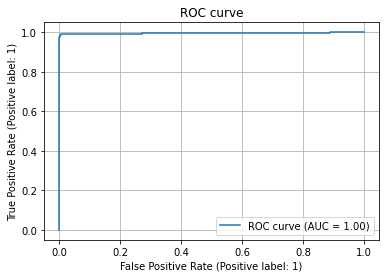

In [88]:
# splitting the dataset
Xt, X, ytr, yv = train_test_split(data_x, data_y, test_size=0.4, random_state=0)

# Preprocessing
Xtr,Xv=Preprocessing(Xt,X,'StandardScaler')

# fitting Kernelised SVM classifier
ksvc = SVC(C=1, class_weight='balanced', gamma=0.1, kernel='poly')
ksvc.fit(Xtr, ytr)

plot_roc_curve(ksvc, Xv, yv, name='ROC curve')
plt.title('ROC curve')
plt.grid()